## Loading the environments

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

True

# Importing packages

In [2]:
from dotenv import load_dotenv
from langchain.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from IPython.display import Image, display
from langgraph.graph import StateGraph , START , END , MessageGraph 
from langchain_core.messages import HumanMessage , AIMessage , SystemMessage
from typing import TypedDict


In [3]:
model = ChatOpenAI(model="gpt-4.1-mini", temperature=0)

In [4]:
model.invoke("Hello, how are you?")

AIMessage(content="Hello! I'm doing great, thank you. How can I assist you today?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 13, 'total_tokens': 29, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_6f2eabb9a5', 'id': 'chatcmpl-BzdzsWCEgZ5RJ1EIf47E5bqxmepRj', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--fc84743b-0515-4c2a-bfbb-81417c59ee8b-0', usage_metadata={'input_tokens': 13, 'output_tokens': 16, 'total_tokens': 29, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

## Some utility functions

In [5]:

# to display the graph
def display_graph(app):
    # this function will display the graph of the app
    try:
        display(Image(app.get_graph().draw_mermaid_png()))
    except Exception as e:
        # This requires some extra dependencies and is optional
        print(e)



# To stream the output of the app
def stream_output(app, input):
    for output in app.stream(input):
        for key,value in output.items():
            print(f"here is output from {key}")
            print("_______")
            print(value)
            print("\n")

In [6]:
# define the state
from typing import Annotated
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages:Annotated[list,add_messages]

## Level 0 : Start with simple worflow

In [10]:
def greet_user(state:State):
    """
    This function will greet the user with a message
    """
    user_message = state["messages"][0].content
    return {"messages" : [f"Hello {user_message}!"]}



In [11]:
#define the graph
graph = StateGraph(State)
graph.add_node("User_greetings" , greet_user)

graph.add_edge(START , "User_greetings")
graph.add_edge("User_greetings" , END)
app = graph.compile()

In [12]:
app.invoke({"messages":"Suman"})

{'messages': [HumanMessage(content='Suman', additional_kwargs={}, response_metadata={}, id='d7bddd3a-c8c0-466d-a7a2-a577be9848cf'),
  HumanMessage(content='Hello Suman!', additional_kwargs={}, response_metadata={}, id='8475f572-c467-4ccb-8e48-7416b4e1ddbb')]}

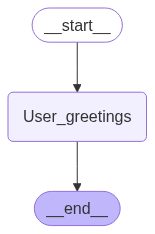

In [13]:
display_graph(app)

## Level 1:    Workflows in a graph

In [14]:
def greet_user(state: State):
    """
    This function will greet the user with a message
    """
    user_message = state["messages"][0].content
    return {"messages": [f"Hello {user_message}!"]}

def convert_to_uppercase(state: State):
    """
    This function will convert the input word to uppercase
    """
    last_message = state["messages"][-1].content
    return {"messages": [last_message.upper()]}


In [17]:
#define the workflow

workflow = StateGraph(State)
workflow.add_node("User_greetings" , greet_user)
workflow.add_node("Uppercase_converter" , convert_to_uppercase)

workflow.add_edge(START , "User_greetings")
workflow.add_edge("User_greetings" , "Uppercase_converter")
workflow.add_edge("Uppercase_converter" , END)
app = workflow.compile()


In [18]:
app.invoke({"messages": "Suman"})

{'messages': [HumanMessage(content='Suman', additional_kwargs={}, response_metadata={}, id='9b8cc871-e9da-4af9-b8ec-91817b5f608d'),
  HumanMessage(content='Hello Suman!', additional_kwargs={}, response_metadata={}, id='480f436e-6e6c-4370-9e2f-bad3bba666c2'),
  HumanMessage(content='HELLO SUMAN!', additional_kwargs={}, response_metadata={}, id='c8daa0b3-dfa9-48af-a8f9-c2a3e9be3b94')]}

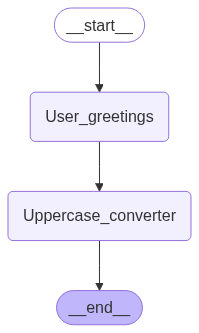

In [19]:
display_graph(app)

In [20]:
stream_output(app, {"messages": "Suman"})

here is output from User_greetings
_______
{'messages': ['Hello Suman!']}


here is output from Uppercase_converter
_______
{'messages': ['HELLO SUMAN!']}




## Level 2 : Using an LLM and a function

In [55]:
def get_response_from_llm(state: State):
    """
    This function will get the response from the LLM
    """
    user_input = state["messages"][0].content
    response = model.invoke(user_input).content
    return {"messages": [response]}


def convert_to_uppercase(state:State):
    """
    This function will convert the message to uppercase
    """
    response_from_llm = state["messages"][-1].content
    uppercase_output = response_from_llm.upper()
    
    return {"messages": [uppercase_output]}



In [56]:
# define the workflow

workflow = StateGraph(State)
workflow.add_node("LLM_response" , get_response_from_llm)
workflow.add_node("Uppercase_converter" , convert_to_uppercase)
workflow.add_edge(START , "LLM_response")
workflow.add_edge("LLM_response" , "Uppercase_converter")
workflow.add_edge("Uppercase_converter" , END)
app = workflow.compile()


In [57]:
app.invoke({"messages": "Hello, how are you?"})

{'messages': [HumanMessage(content='Hello, how are you?', additional_kwargs={}, response_metadata={}, id='8c3f6a4a-89af-4d95-8a45-0e33b391fdc2'),
  HumanMessage(content="Hello! I'm doing well, thank you. How can I assist you today?", additional_kwargs={}, response_metadata={}, id='a7ae887a-b7bf-45fc-a7c9-846f92321c72'),
  HumanMessage(content="HELLO! I'M DOING WELL, THANK YOU. HOW CAN I ASSIST YOU TODAY?", additional_kwargs={}, response_metadata={}, id='dc07abab-7d1c-4660-af5b-30a04a10c810')]}

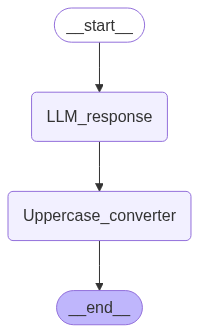

In [58]:
display_graph(app)

In [59]:
stream_output(app, {"messages": "Hello, how are you?"})

here is output from LLM_response
_______
{'messages': ["Hello! I'm doing great, thank you. How can I assist you today?"]}


here is output from Uppercase_converter
_______
{'messages': ["HELLO! I'M DOING GREAT, THANK YOU. HOW CAN I ASSIST YOU TODAY?"]}




## Level 3: real world use case

In [60]:
def classify_sentiment(state:State):
    """
    This function will classify the sentiment of the message
    """
    user_input = state["messages"][0].content
    prompt = f"You are a sentiment classifier. You will be given a message and you will need to classify the sentiment of the message. The sentiment can be positive, negative or neutral. Return the sentiment as a string."
    final_message = user_input + prompt
    response = model.invoke(final_message).content
    return {"messages": [response]}


def get_total_word_count(state):
    """
    This function will get the total word count of the message
    """
    response_from_llm = state["messages"][-1].content
    word_count = len(response_from_llm.split())
    return {"messages": [f"Total word count: {word_count}"]}


In [61]:
workflow = StateGraph(State)
workflow.add_node("Sentiment_classifier" , classify_sentiment)
workflow.add_node("Total_word_counter" , get_total_word_count)
workflow.add_edge(START , "Sentiment_classifier")
workflow.add_edge("Sentiment_classifier" , "Total_word_counter")
workflow.add_edge("Total_word_counter" , END)
app = workflow.compile()

In [63]:
app.invoke({"messages": "I am happy with the quality of the product and the service"})

{'messages': [HumanMessage(content='I am happy with the quality of the product and the service', additional_kwargs={}, response_metadata={}, id='22c3d73c-d722-4bf6-b0c4-5e0cfa973252'),
  HumanMessage(content='positive', additional_kwargs={}, response_metadata={}, id='b967bdd1-0a05-4184-92a0-34bfb501528d'),
  HumanMessage(content='Total word count: 1', additional_kwargs={}, response_metadata={}, id='ec4c8ef4-0c5c-4099-9a3d-9c474e016aa6')]}

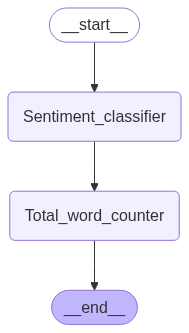

In [64]:
display_graph(app)

In [66]:
stream_output(app, {"messages": "I am happy with the product"})

here is output from Sentiment_classifier
_______
{'messages': ['positive']}


here is output from Total_word_counter
_______
{'messages': ['Total word count: 1']}


